In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

import yfinance as yf
from yahoo_fin import stock_info


ticker = 'ZBRA'
historical_stock_prices = (yf.Ticker(ticker)).history(period = 'max')
historical_stock_prices.to_csv('current/'+ticker+ '.csv')

data = pd.read_csv('current/'+ticker+'.csv')

# data

<h2>Preprocessing</h2>

In [68]:
data = data[['Date', 'Close']]
# data

In [69]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device("mps")

In [70]:
data['Date'] = pd.to_datetime(data['Date'])

# plt.plot(data['Date'], data['Close'])

/var/folders/9q/z460vfh90fs5gczm84vpgyg80000gp/T/ipykernel_69351/3845445604.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [71]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 30
shifted_df = prepare_dataframe_for_lstm(data, lookback)
# shifted_df

In [72]:
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np

In [73]:
# shifted_df_as_np.shape

In [74]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# shifted_df_as_np

In [75]:
# Split into x input, and y output
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

# X.shape, y.shape

In [76]:
X = dc(np.flip(X, axis=1))
# X

<h2>Output</h2>

In [77]:
split_index = int(len(X) * 0.95)
split_index
lookback = 30

In [78]:
# Split 95% into train, 5% into test

X_test = X[split_index:]
y_test = y[split_index:]


In [79]:

X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))


In [80]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_test.shape, y_test.shape

(torch.Size([405, 30, 1]), torch.Size([405, 1]))

In [81]:
# outmodel = LSTM(30, 1, 64, 16, 1)
from  Modules.model import LSTM
outmodel = torch.load('forecast_final.pt').to(device)
outmodel.eval()

LSTM(
  (conv1d): Conv1d(30, 1, kernel_size=(1,), stride=(2,))
  (init_linear): Linear(in_features=1, out_features=1, bias=True)
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sequential): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
)

In [82]:
test_predictions = outmodel(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([402.45984349, 404.65681723, 394.49416957, 394.08333231,
       406.44820031, 398.81969275, 389.91265645, 378.88304598,
       388.75272252, 375.49910379, 371.62034244, 382.36106247,
       371.76710127, 377.85894047, 370.07216075, 367.32170804,
       348.29173785, 344.50187709, 326.93719974, 329.81440863,
       311.62994123, 321.00986303, 333.52852174, 333.25733854,
       341.68882963, 328.81445931, 324.37190799, 324.00151321,
       337.30267917, 320.26466487, 326.16008481, 329.96481092,
       345.32118335, 336.85238317, 335.86485806, 346.10004714,
       336.10044459, 335.27997242, 335.89447945, 332.05506754,
       316.06294667, 308.22342777, 293.89680822, 302.62416699,
       308.1689033 , 295.11259649, 288.52316909, 297.43253722,
       298.61777502, 297.96685155, 309.6696835 , 310.33089976,
       303.86325522, 299.08053167, 295.97393014, 299.73597304,
       303.49419031, 296.1104326 , 305.29688634, 301.34869874,
       293.1992666 , 293.14583517, 294.69674946, 291.11

In [83]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
# new_y_test

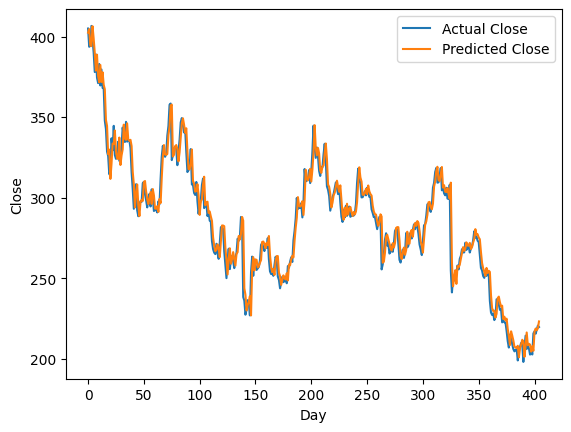

In [84]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


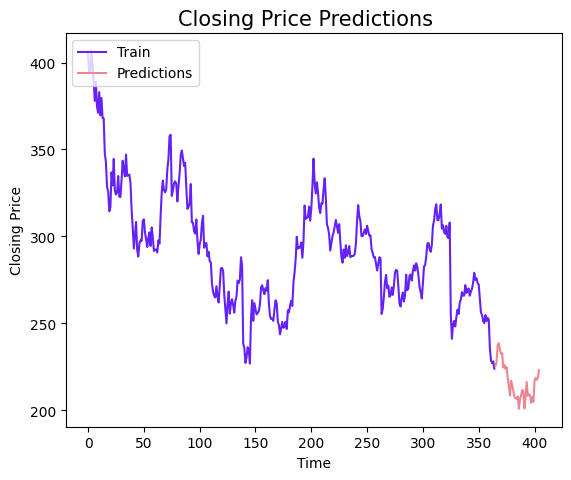

In [85]:
def plot_model_predictions(test, preds):
    plot_test = pd.DataFrame(data=test, index=range(test_predictions.size), columns=['Close'])
    plot_test['Day'] = plot_test.index
    plot_test = plot_test[:int(np.ceil(len(plot_test) * 0.9))]
    plot_pred = pd.DataFrame(data=preds, index=range(new_y_test.size), columns=['Predictions'])
    plot_pred['Day'] = plot_pred.index
    plot_pred = plot_pred[int(np.ceil(len(plot_pred) * 0.9)):]

    # fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    # axes[2][1].set_visible(False)
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 15)

    # plt.facecolor('black')
    plt.plot(plot_test['Day'], plot_test['Close'], color = '#6522F5', label = 'Train')
    plt.plot(plot_pred['Day'], plot_pred['Predictions'], color = '#EB8791', label = 'Predictions')
    # plt.set_title('Meta', fontsize = 30)
    plt.xlabel('Time', fontsize = 10)
    plt.ylabel('Closing Price', fontsize = 10)
    # plt.xaxis.set_tick_params(labelsize = 18)
    # plt.yaxis.set_tick_params(labelsize = 18)
    plt.legend(loc = 'upper left', fontsize = 10)
    
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(new_y_test, test_predictions)